# Model Selection 
___

**Objective:** Select a model that can achieve a Mean Absolute Error of up to R$ 500 in mothly income prediction.  
 
- **MAE** was selected as the metric because it is easy to interpret and appropriate for the salary scenario.   
- The threshold of **R$ 500** was selected because it is reasonable for the data range and adds up to a prediction margin of R$ 1,000.   

**Process:**

1. Import libraries, modules, functions, classes, and the dataset
2. Train a baseline model and evaluate its performance
    - I'll use a default Random Forest because I think the reasoning to determine salary is similar to a tree-thought process.
    - Although it has robust internal mechanisms to generalize predictions, everytime I run the code, I'll test a different parameter that seems appropriate and will note fit time and performance
3. Train and optmize a boosting method to compare against bagging
    - I'll start with LightGBM because it's faster.
    - If necessary, I can use XGBoost or CatBoost
4. Evaluate whether a combination of models will work better than a single model
____

## 1. Importing

In [1]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Project variables and functions
import config 
import utils
from preprocessing import pre_processing, divide_train_test
import importlib
importlib.reload(utils)

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models and metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score


Importing and dividing the data:

In [2]:
# Imports data and divide it into training and testing
X_train, X_test, y_train, y_test = divide_train_test(
    utils.read_compressed_data(config.COLLECTED_DATA_PATH),
    config.FEATURES,
    config.TARGET
)

# Shows first lines on X_train
X_train.head()

,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,weekly_worked_hours_all_jobs
206997,DF,57,2,4,1,3,9,4,11,9,2,3,40
653228,CE,33,1,4,1,7,16,7,8,2,1,3,40
596722,PR,22,2,1,1,6,13,1,7,4,1,3,40
322304,BA,24,1,4,1,5,12,1,10,5,1,4,48
121644,AM,45,1,1,1,2,6,9,5,8,2,4,45


___

## 2. Baseline Model (Random Forest):

Notes:
- RandomForestRegressor(random_state=0) takes 7 min to fit and achieve a 790 MAE with 50% R²
- RandomForestRegressor(random_state=0, n_estimators=400) takes 40 min to fit and achieve a 786 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=8) takes 3 min to fit and achieve a 860 MAE with 45% R2
- RandomForestRegressor(random_state=0, max_depth=32) takes 8 min to fit and achieve a 788 MAE with 51% R²
- RandomForestRegressor(random_state=0, max_depth=24) takes 10 min to fit and achieve a 785 MAE with 52% R²
- RandomForestRegressor(random_state=0, min_samples_split=8) takes 6 min to fit and achieve a 787 MAE with 52% R²
- RandomForestRegressor(random_state=0, min_samples_split=16) takes 6 min to fit and achieve a 782 MAE with 53% R²

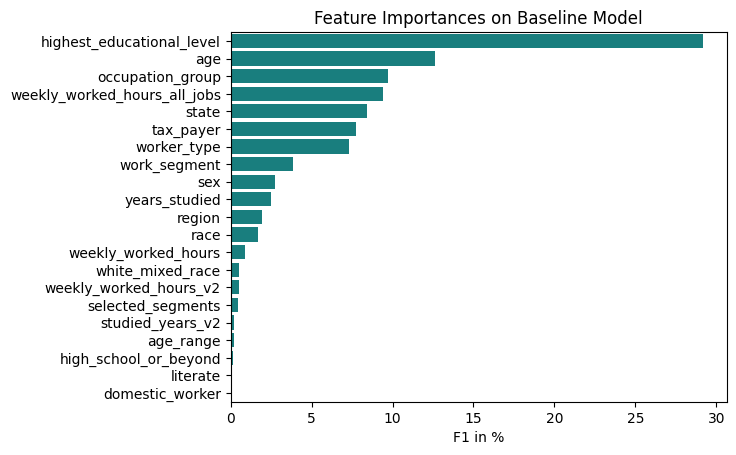

In [3]:
# Creates a baseline pipeline using default random forest
baseline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', RandomForestRegressor(random_state=0, min_samples_split=16))
    ]
)

# Fits 
baseline.fit(X_train, y_train)

# Evaluates feature importance
features = list(X_train.columns) # original features

# Appends new features
for i in range(len(baseline['pre_processing'])-1):
    features.append(baseline['pre_processing'][i].get_params()['new_feature_name'])

# Obtains feature importances and multiply by 100 to make a percentage
fi = np.array(baseline['model'].feature_importances_) * 100

# Combines everything in a Series
fi_series = pd.Series(fi, index=features)

# Sorts fi_series
fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=fi_series.index,
    values=fi_series,
    title='Feature Importances on Baseline Model',
    x_label='F1 in %'
)

Evaluating predictions with MAE and other complementary metrics:

In [4]:
baseline_pred = baseline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, baseline_pred)}')
print(f'MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, baseline_pred))}')

MSE: 1558381.9046386273
MAE: 782.8445187626401
R²:  53.10%


**In Summary:**
- A simple Random Forest performs relatively well, but does not achieve the expected MAE.
- Some features almost have no importance to the algorithm as it extracts more information from the original variables than the created ones.
- Since it's a costly model to fit and already is somewhat robust with default parameters, I'll leave it as it is, and will analyze how other models perform
___

## 3. Boosting Method (LightGBM)

Notes:
- LGBMRegressor(random_state=0) fits in 7 seconds, and achieves a 811 MAE with 50% R²
- Optmization for LGBMRegressor took 17 minutes to find the best estimator to have 200 estimators, 100 leaves, MAE 795, and R² of 52%.
- LGBMRegressor(random_state=0, n_estimators=300, num_leaves=100, force_row_wise=True) fits in 19 seconds, and achieves a 793 MAE with R² of 52%.
- LGBMRegressor(random_state=0, n_estimators=500, num_leaves=200, force_row_wise=True) fits in 28 seconds, and achieves a 782 MAE with R² of 53%.

In [9]:
# Creates a pipeline
lgbm_pipeline = Pipeline(
    steps=[
        ('pre_processing', pre_processing),
        ('model', LGBMRegressor(random_state=0, n_estimators=500, num_leaves=200, force_row_wise=True))
    ]
)

# Fits
lgbm_pipeline.fit(X_train, y_train)

# Predicts
lgbm_pred = lgbm_pipeline.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 21
[LightGBM] [Info] Start training from score 2201.854054
MSE: 1548075.6026395012
MAE: 782.073329944892
R²:  53.41%


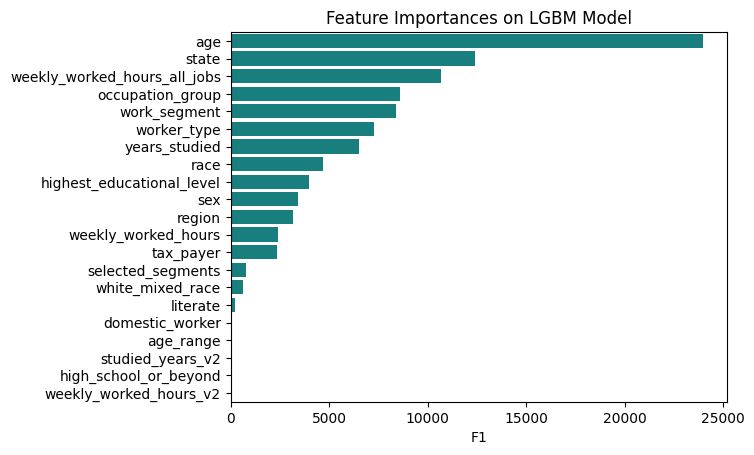

In [6]:
# Obtains feature importances 
lgbm_fi = np.array(lgbm_pipeline['model'].feature_importances_)

# Combines everything in a Series
lgbm_fi_series = pd.Series(lgbm_fi, index=features)

# Sorts fi_series
lgbm_fi_series.sort_values(ascending=False, inplace=True)

# Plots ranking
utils.show_barplot(
    cat=lgbm_fi_series.index,
    values=lgbm_fi_series,
    title='Feature Importances on LGBM Model',
    x_label='F1'
)

Optmizing LightGBM with GridSearchCV as it has short fit time:

In [ ]:
# Creates a param_grid
lgbm_params = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [50, 100, 200],
    'model__num_leaves': [31, 50, 100],
    'model__force_row_wise': [True]
}

# Creates the GridSearch
lgbm_grid_search = GridSearchCV(lgbm_pipeline, lgbm_params, cv=4, n_jobs=-1, scoring='neg_mean_absolute_error')

#Fits
lgbm_grid_search.fit(X_train, y_train)

In [17]:
# Understaning best model params
best_lgbm = lgbm_grid_search.best_estimator_
best_lgbm['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'force_row_wise': True}

In [18]:
lgbm_pred = best_lgbm.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, lgbm_pred )}')
print(f'MAE: {mean_absolute_error(y_test, lgbm_pred )}')
print(f'R²: {utils.make_percentage(r2_score(y_test, lgbm_pred ))}')

MSE: 1591379.4303732717
MAE: 795.3111452950363
R²:  52.10%


**In Summary:**
- LightGBM was fast, but did not achieve expected MAE or performed better than Random Forest
- Changing hyperparameters a little approximates performance from Random Forest, suggesting it's more a problem with the data (target predictability and feature engineering) than with the model.
- For now, I won't test CatBoost or XGBoost - I need to visualize how the models are predicting
_____

## 4. Evaluating and Combining Models

Sampling some observations to understand how models are predicting income: 

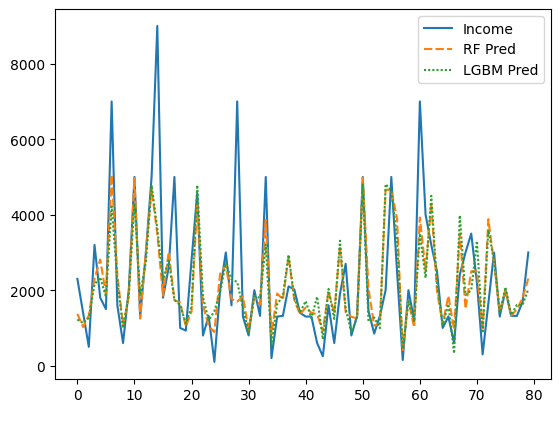

In [7]:
# Sampling n observations
n = 80
sample = X_test.sample(n, random_state=0)
sample_y = y_test[sample.index]

# Predicting using models
rf_sample_pred = baseline.predict(sample)
lgbm_sample_pred = lgbm_pipeline.predict(sample)

# Constructs a DataFrame to compare
sample_pred_df = pd.DataFrame({'Income': sample_y, 'RF Pred': rf_sample_pred, 'LGBM Pred': lgbm_sample_pred})
sample_pred_df.index = list(range(n))
ax = sns.lineplot(data=sample_pred_df)
ax.set_xlabel(' ')
plt.show()

The predictions follow the variance in income, but suffer specially with peaks in the target that are much higher than expected.   
I'll confirm this, plotting the MAE per each thousand R$ in the target.

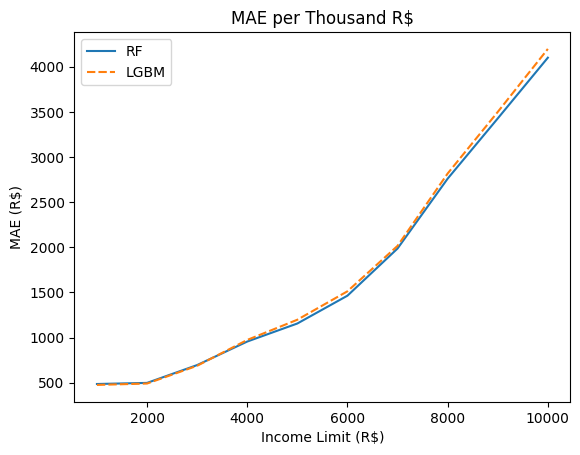

In [10]:
rf_maes = {}
lgbm_maes = {}

for income_limit in range(1000, 11000, 1000):
    # Diving y_test/x_test in segments of thousand R$
    if income_limit == 1000:
        initial_limit = 0
    else:
        initial_limit = income_limit - 999
    
    income_segment_bool = (y_test >= initial_limit) & (y_test < income_limit)
    income_segment_indexes = list(y_test[income_segment_bool].index)
    y_test_divided = y_test[income_segment_indexes]
    X_test_divided = X_test.loc[income_segment_indexes]

    # Predicting on X_test_divided
    rf_preds = baseline.predict(X_test_divided)
    lgbm_preds = lgbm_pipeline.predict(X_test_divided)

    # Storing maes
    rf_maes[income_limit] = mean_absolute_error(y_test_divided, rf_preds)
    lgbm_maes[income_limit] = mean_absolute_error(y_test_divided, lgbm_preds)

# Analyse MAES
maes_per_thousand = pd.DataFrame({'RF': rf_maes.values(), 'LGBM': lgbm_maes.values()}, index=rf_maes.keys())
ax = sns.lineplot(maes_per_thousand)
plt.title('MAE per Thousand R$')
ax.set_ylabel('MAE (R$)')
ax.set_xlabel('Income Limit (R$)')
plt.show()


As expected, predictions become less accurate with higher income ranges.   
Interestingly, a 500 MAE is achieved within the first R$ 2,000.

Plotting distributtion of target and predictions:

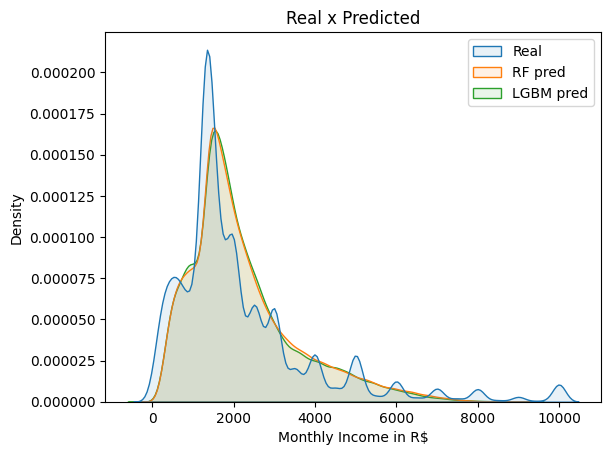

In [17]:
# Creates a DF to store target and predictions
target_preds = pd.DataFrame({'Real': y_test, 'RF pred': baseline_pred, 'LGBM pred': lgbm_pred})
ax = sns.kdeplot(data=target_preds, fill=True, alpha=0.1)
ax.set_xlabel('Monthly Income in R$')
plt.title('Real x Predicted')
plt.show()

**In Summary:**
- RF and LGBM perform almost identically
- Combining them may result in some improvement, but as their weaknesses are very similar, they might not help each other really much.
- Also, considering they are performing relatively well with the data they have, a 700 hundred MAE seems more realistic unless we collect more data, do more feature engineering or switch to another kind of models (linear, neural networks, etc.)

Testing combining LGBM and RF:

RF MAE: 782.8445187626401
LGBM MAE: 782.073329944892


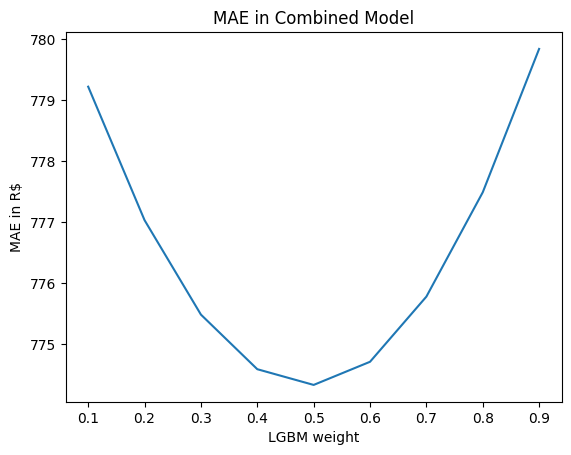

In [18]:
print(f'RF MAE: {mean_absolute_error(y_test, baseline_pred)}')
print(f'LGBM MAE: {mean_absolute_error(y_test, lgbm_pred)}')

results = {}

# Initialize looping and changing rf_weight
for rf_weight in range(9, 0, -1):
    rf_weight = rf_weight / 10
    lgbm_weight = 1 - rf_weight

    weighted_pred = baseline_pred * rf_weight + lgbm_pred * lgbm_weight
    results[rf_weight] = mean_absolute_error(y_test, weighted_pred)

ax = sns.lineplot(data=results)
plt.title('MAE in Combined Model')
ax.set_ylabel('MAE in R$')
ax.set_xlabel('LGBM weight')
plt.show()


Averaging predictions results in a small reduction in MAE.   

Trying to stack predictors:

In [28]:
# Creating a predictor to use a previous predictor as the learning point
residuals_lgbm = LGBMRegressor(random_state=0, force_col_wise=True)

# Obtaining the residuals from RF during training
residuals_train = baseline.predict(X_train)

# Reshaping residuals_train
residuals_train = residuals_train.reshape(-1, 1)

# Trains LGBM with baseline_predictions and real income
residuals_lgbm.fit(residuals_train, y_train)

# Predicts and evaluates
residuals_lgbm_pred = residuals_lgbm.predict(baseline_pred.reshape(-1, 1))

print(f'MSE: {mean_squared_error(y_test, residuals_lgbm_pred)}')
print(f'MAE: {mean_absolute_error(y_test, residuals_lgbm_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, residuals_lgbm_pred))}')

[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 1
[LightGBM] [Info] Start training from score 2201.854054
MSE: 1611523.0489881611
MAE: 780.8767069646387
R²:  51.50%


It looks like averaging predictions is still better than stacking them. 

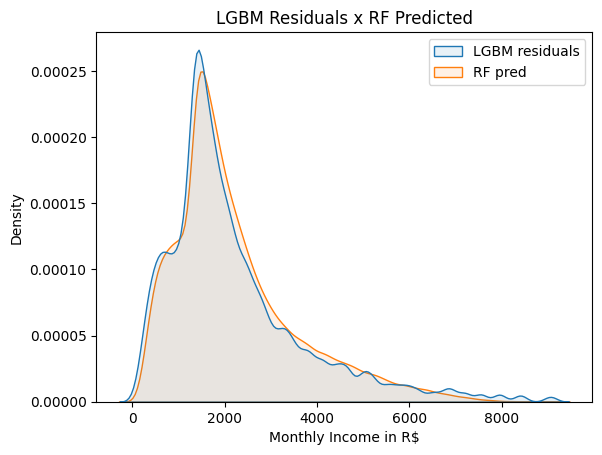

In [33]:
target_preds['LGBM residuals'] = residuals_lgbm_pred
ax = sns.kdeplot(data=target_preds[['LGBM residuals', 'RF pred']], fill=True, alpha=0.1)
ax.set_xlabel('Monthly Income in R$')
plt.title('LGBM Residuals x RF Predicted')
plt.show()

Trying to stack a linear model as a final estimator:

In [34]:
# Creating a predictor to use a previous predictor as the learning point
residuals_linear = ElasticNet(random_state=0)

# Trains ElasticNet with baseline_predictions and real income
residuals_linear.fit(residuals_train, y_train)

# Predicts and evaluates
residuals_linear_pred = residuals_linear.predict(baseline_pred.reshape(-1, 1))

print(f'MSE: {mean_squared_error(y_test, residuals_linear_pred)}')
print(f'MAE: {mean_absolute_error(y_test, residuals_linear_pred)}')
print(f'R²: {utils.make_percentage(r2_score(y_test, residuals_linear_pred))}')

MSE: 1598108.0404171452
MAE: 793.074343513709
R²:  51.90%


To finish, I'll create a final model combining RF and LGBM and use cross_val_score across the entire dataset for all models here, to get an estimate of the MAE I'll accept for the model in production.    
The model to go to production will be the one with better score:

In [41]:
# Creates final models
final_rf = Pipeline(steps=[('pre processing', pre_processing), ('model', RandomForestRegressor(random_state=0, min_samples_split=16))])
final_lgbm = LGBMRegressor(random_state=0, force_col_wise=True, n_estimators=500, num_leaves=200)
final_lgbm_pipeline = Pipeline(steps=[('pre processing', pre_processing), ('model', final_lgbm)])
stacked_rf_lgbm = StackingRegressor( estimators=[('rf', final_rf)], final_estimator= final_lgbm)

# Concatenates X and y
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# Storing results
rf_scores = np.array(cross_val_score(final_rf, X, y, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)) * -1
lgbm_scores = np.array(cross_val_score(final_lgbm, X, y, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)) * -1
stacked_scores = np.array(cross_val_score(stacked_rf_lgbm, X, y, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)) * -1

# Storing means and std
means = [rf_scores.mean(), lgbm_scores.mean(), stacked_scores.mean()]
stds = [rf_scores.std(), lgbm_scores.std(), stacked_scores.std()]

# Selecting best model
least_mean_idx = np.argmin(means)
least_std_idx = np.argmin(stds)
best_model = lambda x: 'Random Forest' if x==0 else ('LGBM' if x==1 else 'Stacked')

#Print
print(f'Model with least MAE mean: {best_model(least_mean_idx)}')
print(f'Model with least MAE std: {best_model(least_std_idx)}')

Model with least MAE mean: Stacked
Model with least MAE std: LGBM


After almost 1 hour, we got a result. Let's explore it more in depth:

In [45]:
# Saves in a DataFrame
df_scores = pd.DataFrame({'RF': rf_scores, 'LGBM': lgbm_scores, 'Stacked': stacked_scores}, index=range(1,5))
df_scores

,RF,LGBM,Stacked
1,787.158566,784.250048,783.899795
2,786.920548,784.149472,783.598802
3,786.148067,782.990054,782.721000
4,784.432838,782.735537,781.021266


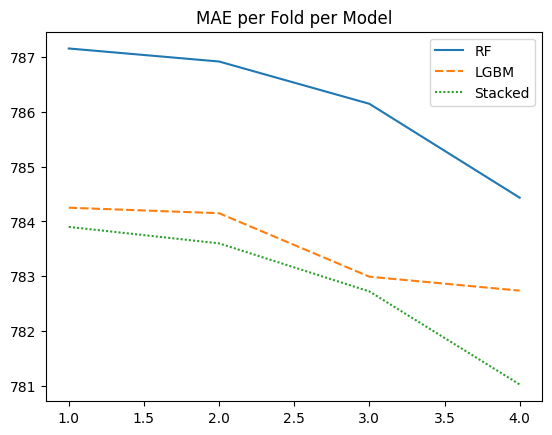

In [46]:
#Plots
sns.lineplot(df_scores)
plt.title('MAE per Fold per Model')
plt.show()

It's clear that a stacked model performed slightly better at each fold, but are these differences significant?   
Furthermore, I forgot to add a model that uses a weighted avarage

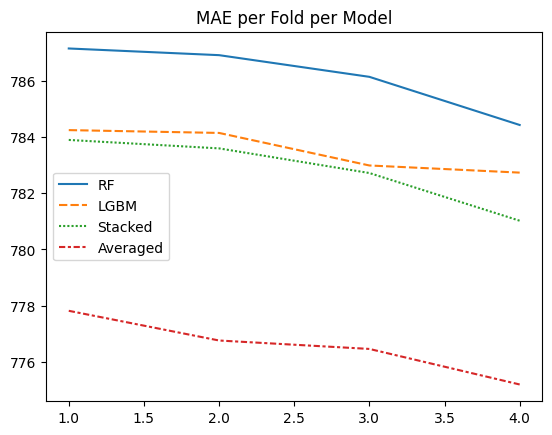

In [47]:
from sklearn.ensemble import VotingRegressor

vr = VotingRegressor(estimators=[('rf', final_rf), ('lgbm', final_lgbm_pipeline)])

vr_scores = np.array(cross_val_score(vr, X, y, cv=4, scoring='neg_mean_absolute_error', n_jobs=-1)) * -1

# Adds to dataframe and plot again
df_scores['Averaged'] = vr_scores
sns.lineplot(df_scores)
plt.title('MAE per Fold per Model')
plt.show()

Testing statisticall significance:

In [54]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Friedman Test
stat, p = friedmanchisquare(df_scores['RF'], df_scores['LGBM'], df_scores['Stacked'], df_scores['Averaged'])
print(f'Friedman Stat: {stat}, p-value: {p}')

if p < 0.05:
    print("Differences were significant")
    
    # Post-hoc Nemenyi Test
    nemenyi_results = sp.posthoc_nemenyi_friedman(df_scores)
    print(nemenyi_results)
else:
    print("Differences were not significant")

Friedman Stat: 12.0, p-value: 0.007383160505359769
Differences were significant
                RF      LGBM   Stacked  Averaged
RF        1.000000  0.670273  0.125527  0.005604
LGBM      0.670273  1.000000  0.670273  0.125527
Stacked   0.125527  0.670273  1.000000  0.670273
Averaged  0.005604  0.125527  0.670273  1.000000


Overall, I can say scores were statiscally different because the **Avaraged** model performs better than **Random Forest**.    
However, from a hypothesis testing perspective, I can't garantee the avaraged is better than stacked or LGBM, even though I can believe it.

In [62]:
# Testing which percentage of rows fall within the MAE margin for the Averaged Model:
vr.fit(X_train, y_train)
vr_preds = vr.predict(X_test)

mae = mean_absolute_error(y_test, vr_preds)

test = (y_test > vr_preds + mae) | (y_test < vr_preds - mae)

print(f'Percentage of times where y_test fell within a R$ {mae :.2f} margin: {utils.make_percentage(1 - test.mean())}')

[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 578261, number of used features: 20
[LightGBM] [Info] Start training from score 2201.854054
Percentage of times where y_test fell within a R$ 775.08 margin:  68.33%
